In [1]:
import time
import os
import sys
sys.path.append('..')

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats
import utils.plot

import torchvision

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
resolution='5'
resDir='/media/xinyi/T7 Shield/neuro/results/plots/cnnvaeexp0_segNucall'
with open(os.path.join(resDir,'leiden_res'+resolution), 'rb') as output:
    finalPartition=pickle.load(output)
    
savedir_baseline='/media/xinyi/T7 Shield/neuro/results/jointClustering/baseline/res'+resolution
saveDir=os.path.join(savedir_baseline,'cnnvaeexp0_segNucall')
with open(os.path.join(saveDir,'metadataClf','exp0_pathDiagClf_modSilFilter_2','log','clusterUsed'), 'rb') as output:
    finalPartition_keep=pickle.load(output)

In [3]:
finalPartition_keepIdx=np.repeat(False, finalPartition.size)
for c in finalPartition_keep:
    finalPartition_keepIdx[finalPartition==c]=True
finalPartition_keep_input=np.copy(finalPartition)
finalPartition_keep_input[np.logical_not(finalPartition_keepIdx)]=-1
print(finalPartition_keep_input.shape)
print(np.unique(finalPartition_keep_input))

(97530,)
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  28  30  31  32  34  35  36  38
  39  40  43  44  46  49  53  55  56  58  60  62  63  66  68  70  71  73
  74  78  82  84  85  86  87  94  95  96  97  99 100 101 102]


In [4]:
savedir_processed='/media/xinyi/T7 Shield/neuro/processed'

with open(os.path.join(savedir_processed,'allImgs_noMaxPerc_minmax_segNuc'), 'rb') as output:
    allImg=pickle.load(output)
print(allImg.shape)

(97530, 4, 128, 128)


In [5]:
imgSize=allImg.shape[2]
stains=np.array(['DAPI','GFAP','MAP2','LMNB'])
inputstain='DAPI'
allImg=allImg[:,[0,2,3]]
allImg.shape

(97530, 3, 128, 128)

In [6]:
seed=3
epochs=5001
saveFreq=50
lr=0.0001
weight_decay=0 

batchsize=256


dropout=0.01

name='img2clusterID_dapi_lmnb_map2'
modelname_train='resnet18'
savepath_curr=os.path.join(saveDir,'clusterClf',name)
if not os.path.exists(os.path.join(saveDir,'clusterClf')):
    os.mkdir(os.path.join(saveDir,'clusterClf'))
if not os.path.exists(savepath_curr):
    os.mkdir(savepath_curr)
logsavepath=os.path.join(savepath_curr,'log')
modelsavepath=os.path.join(savepath_curr,'model')
plotsavepath=os.path.join(savepath_curr,'plots')


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)



In [7]:
def train(epoch,model_clf,optimizer_clf,inputImgs,inputImgs_val,labels_train,labels_val):
    np.random.seed(3)
    train_nodes_idx=np.arange(labels_train.size()[0])
    val_nodes_idx=np.arange(labels_val.size()[0])
    np.random.shuffle(train_nodes_idx)
    t = time.time()
    model_clf.train()
    loss_all=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
        trainInput=torch.tensor(inputImgs[trainIdx]).cuda().float()

        optimizer_clf.zero_grad()

        pred = model_clf(trainInput)

        loss=loss_clf(pred, train_labels)
        loss_all+=loss.item()
            
        loss.backward()
        optimizer_clf.step()

    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_clf.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
            valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


            pred = model_clf(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()

        loss_val_all=loss_val_all/nvalBatches
    
    print(' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_val: {:.4f}'.format(loss_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_val_all


sample 0


<ipython-input-7-0af1aa155378>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
<ipython-input-7-0af1aa155378>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 2.3129 loss_val: 1.7465 time: 51.2614s
 Epoch: 0001 loss_train: 1.6228 loss_val: 1.6688 time: 50.7702s
 Epoch: 0002 loss_train: 1.4313 loss_val: 1.6782 time: 51.1746s
 Epoch: 0003 loss_train: 1.2294 loss_val: 1.7676 time: 51.5446s
 Epoch: 0004 loss_train: 0.9869 loss_val: 1.9588 time: 50.1232s
 Epoch: 0005 loss_train: 0.7409 loss_val: 2.0971 time: 50.7514s
 Epoch: 0006 loss_train: 0.5444 loss_val: 2.2471 time: 50.2678s
 Epoch: 0007 loss_train: 0.4337 loss_val: 2.6047 time: 50.3347s
 Epoch: 0008 loss_train: 0.3759 loss_val: 2.6056 time: 50.2043s
 Epoch: 0009 loss_train: 0.3204 loss_val: 2.7325 time: 50.3408s
 Epoch: 0010 loss_train: 0.2688 loss_val: 2.7861 time: 50.2651s
 Epoch: 0011 loss_train: 0.2162 loss_val: 2.8192 time: 50.3793s
 Epoch: 0012 loss_train: 0.1679 loss_val: 2.9180 time: 50.2003s
 Epoch: 0013 loss_train: 0.1390 loss_val: 3.1180 time: 50.2365s
 Epoch: 0014 loss_train: 0.1140 loss_val: 3.0689 time: 49.9817s
 Epoch: 0015 loss_train: 0.0897 loss_val

 Epoch: 0131 loss_train: 0.0001 loss_val: 5.7959 time: 50.8193s
 Epoch: 0132 loss_train: 0.0001 loss_val: 5.8434 time: 50.3783s
 Epoch: 0133 loss_train: 0.0001 loss_val: 5.8886 time: 50.3644s
 Epoch: 0134 loss_train: 0.0001 loss_val: 5.9307 time: 50.3526s
 Epoch: 0135 loss_train: 0.0001 loss_val: 5.9713 time: 50.3133s
 Epoch: 0136 loss_train: 0.0000 loss_val: 6.0100 time: 50.3217s
 Epoch: 0137 loss_train: 0.0000 loss_val: 6.0486 time: 50.0888s
 Epoch: 0138 loss_train: 0.0000 loss_val: 6.0847 time: 50.3273s
 Epoch: 0139 loss_train: 0.0000 loss_val: 6.1208 time: 50.1647s
 Epoch: 0140 loss_train: 0.0000 loss_val: 6.1563 time: 50.3791s
 Epoch: 0141 loss_train: 0.0000 loss_val: 6.1913 time: 50.5005s
 Epoch: 0142 loss_train: 0.0000 loss_val: 6.2250 time: 50.8782s
 Epoch: 0143 loss_train: 0.0000 loss_val: 6.2579 time: 50.2502s
 Epoch: 0144 loss_train: 0.0000 loss_val: 6.2909 time: 50.1394s
 Epoch: 0145 loss_train: 0.0000 loss_val: 6.3228 time: 50.1952s
 Epoch: 0146 loss_train: 0.0000 loss_val

 Epoch: 0260 loss_train: 0.0000 loss_val: 7.4091 time: 50.3208s
 Epoch: 0261 loss_train: 0.0000 loss_val: 7.4409 time: 50.3852s
 Epoch: 0262 loss_train: 0.0000 loss_val: 7.4715 time: 50.4046s
 Epoch: 0263 loss_train: 0.0000 loss_val: 7.5010 time: 50.4445s
 Epoch: 0264 loss_train: 0.0000 loss_val: 7.5310 time: 50.1534s
 Epoch: 0265 loss_train: 0.0000 loss_val: 7.5606 time: 50.6771s
 Epoch: 0266 loss_train: 0.0000 loss_val: 7.5908 time: 50.3046s
 Epoch: 0267 loss_train: 0.0000 loss_val: 7.6202 time: 50.4629s
 Epoch: 0268 loss_train: 0.0000 loss_val: 7.6528 time: 50.3977s
 Epoch: 0269 loss_train: 0.0000 loss_val: 7.6820 time: 50.5702s
 Epoch: 0270 loss_train: 0.0000 loss_val: 7.7122 time: 50.5032s
 Epoch: 0271 loss_train: 0.0000 loss_val: 7.7438 time: 50.3733s
 Epoch: 0272 loss_train: 0.0000 loss_val: 7.7687 time: 50.3561s
 Epoch: 0273 loss_train: 0.0000 loss_val: 7.7929 time: 50.3888s
 Epoch: 0274 loss_train: 0.0000 loss_val: 7.8088 time: 50.7293s
 Epoch: 0275 loss_train: 0.0000 loss_val

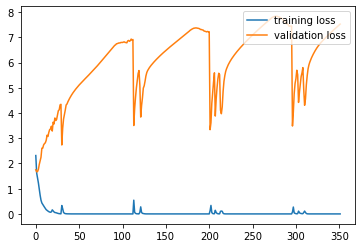

sample 1


<ipython-input-7-0af1aa155378>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
<ipython-input-7-0af1aa155378>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 2.3235 loss_val: 1.7721 time: 50.9069s
 Epoch: 0001 loss_train: 1.6275 loss_val: 1.6628 time: 49.7216s
 Epoch: 0002 loss_train: 1.4435 loss_val: 1.6471 time: 49.5298s
 Epoch: 0003 loss_train: 1.2548 loss_val: 1.6740 time: 49.9713s
 Epoch: 0004 loss_train: 1.0172 loss_val: 1.8338 time: 49.6383s
 Epoch: 0005 loss_train: 0.7694 loss_val: 2.1030 time: 49.8127s
 Epoch: 0006 loss_train: 0.5771 loss_val: 2.3275 time: 49.8283s
 Epoch: 0007 loss_train: 0.4552 loss_val: 2.4463 time: 49.7799s
 Epoch: 0008 loss_train: 0.3808 loss_val: 2.5431 time: 49.8545s
 Epoch: 0009 loss_train: 0.3255 loss_val: 2.8147 time: 50.0831s
 Epoch: 0010 loss_train: 0.2774 loss_val: 2.8116 time: 50.8071s
 Epoch: 0011 loss_train: 0.2247 loss_val: 2.8881 time: 59.3143s
 Epoch: 0012 loss_train: 0.1911 loss_val: 2.8328 time: 68.8180s
 Epoch: 0013 loss_train: 0.1490 loss_val: 2.9835 time: 66.6128s
 Epoch: 0014 loss_train: 0.1199 loss_val: 3.2411 time: 67.1234s
 Epoch: 0015 loss_train: 0.0998 loss_val

 Epoch: 0129 loss_train: 0.0002 loss_val: 5.5216 time: 50.1112s
 Epoch: 0130 loss_train: 0.0001 loss_val: 5.5748 time: 50.1369s
 Epoch: 0131 loss_train: 0.0001 loss_val: 5.6239 time: 50.0003s
 Epoch: 0132 loss_train: 0.0001 loss_val: 5.6698 time: 50.2985s
 Epoch: 0133 loss_train: 0.0001 loss_val: 5.7138 time: 50.0722s
 Epoch: 0134 loss_train: 0.0001 loss_val: 5.7564 time: 49.9598s
 Epoch: 0135 loss_train: 0.0001 loss_val: 5.7979 time: 50.1849s
 Epoch: 0136 loss_train: 0.0000 loss_val: 5.8379 time: 50.0293s
 Epoch: 0137 loss_train: 0.0000 loss_val: 5.8763 time: 50.2242s
 Epoch: 0138 loss_train: 0.0000 loss_val: 5.9141 time: 50.0645s
 Epoch: 0139 loss_train: 0.0000 loss_val: 5.9513 time: 50.2482s
 Epoch: 0140 loss_train: 0.0000 loss_val: 5.9874 time: 49.9269s
 Epoch: 0141 loss_train: 0.0000 loss_val: 6.0225 time: 50.0962s
 Epoch: 0142 loss_train: 0.0000 loss_val: 6.0575 time: 50.3226s
 Epoch: 0143 loss_train: 0.0000 loss_val: 6.0908 time: 50.0235s
 Epoch: 0144 loss_train: 0.0000 loss_val

 Epoch: 0260 loss_train: 0.0000 loss_val: 7.8500 time: 50.0321s
 Epoch: 0261 loss_train: 0.0000 loss_val: 7.8644 time: 49.9978s
 Epoch: 0262 loss_train: 0.0000 loss_val: 7.8704 time: 50.0369s
 Epoch: 0263 loss_train: 0.0000 loss_val: 7.8794 time: 49.8428s
 Epoch: 0264 loss_train: 0.0000 loss_val: 7.8741 time: 49.9766s
 Epoch: 0265 loss_train: 0.0000 loss_val: 7.8725 time: 49.8452s
 Epoch: 0266 loss_train: 0.0000 loss_val: 7.8597 time: 50.1238s
 Epoch: 0267 loss_train: 0.0000 loss_val: 7.8402 time: 49.8025s
 Epoch: 0268 loss_train: 0.0000 loss_val: 7.8184 time: 49.9949s
 Epoch: 0269 loss_train: 0.0000 loss_val: 7.7922 time: 49.9057s
 Epoch: 0270 loss_train: 0.0000 loss_val: 7.7539 time: 50.0059s
 Epoch: 0271 loss_train: 0.0000 loss_val: 7.7183 time: 50.0831s
 Epoch: 0272 loss_train: 0.0000 loss_val: 7.6827 time: 50.0104s
 Epoch: 0273 loss_train: 0.0000 loss_val: 7.6371 time: 50.0020s
 Epoch: 0274 loss_train: 0.0000 loss_val: 7.5831 time: 49.8103s
 Epoch: 0275 loss_train: 0.0000 loss_val

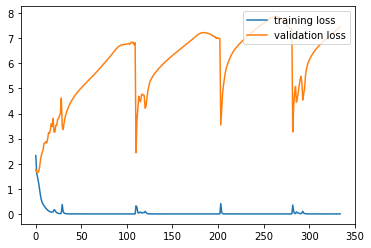

sample 2


<ipython-input-7-0af1aa155378>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
<ipython-input-7-0af1aa155378>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 2.3033 loss_val: 1.8411 time: 49.3993s
 Epoch: 0001 loss_train: 1.6273 loss_val: 1.7308 time: 49.5270s
 Epoch: 0002 loss_train: 1.4421 loss_val: 1.7213 time: 49.4220s
 Epoch: 0003 loss_train: 1.2494 loss_val: 1.7163 time: 49.5628s
 Epoch: 0004 loss_train: 1.0099 loss_val: 1.8566 time: 49.4897s
 Epoch: 0005 loss_train: 0.7759 loss_val: 2.0871 time: 49.4669s
 Epoch: 0006 loss_train: 0.5738 loss_val: 2.2102 time: 49.6376s
 Epoch: 0007 loss_train: 0.4479 loss_val: 2.4077 time: 49.3390s
 Epoch: 0008 loss_train: 0.3618 loss_val: 2.6698 time: 49.5525s
 Epoch: 0009 loss_train: 0.2940 loss_val: 2.6619 time: 49.4864s
 Epoch: 0010 loss_train: 0.2424 loss_val: 2.9114 time: 49.7779s
 Epoch: 0011 loss_train: 0.2148 loss_val: 2.9811 time: 49.3189s
 Epoch: 0012 loss_train: 0.1737 loss_val: 2.9836 time: 49.4654s
 Epoch: 0013 loss_train: 0.1543 loss_val: 3.1532 time: 49.4596s
 Epoch: 0014 loss_train: 0.1244 loss_val: 3.2055 time: 49.7721s
 Epoch: 0015 loss_train: 0.1028 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 6.2860 time: 50.5057s
 Epoch: 0130 loss_train: 0.0000 loss_val: 6.3292 time: 49.8898s
 Epoch: 0131 loss_train: 0.0000 loss_val: 6.3704 time: 51.1228s
 Epoch: 0132 loss_train: 0.0000 loss_val: 6.4117 time: 50.4048s
 Epoch: 0133 loss_train: 0.0000 loss_val: 6.4510 time: 50.6761s
 Epoch: 0134 loss_train: 0.0000 loss_val: 6.4899 time: 50.4294s
 Epoch: 0135 loss_train: 0.0000 loss_val: 6.5278 time: 50.2957s
 Epoch: 0136 loss_train: 0.0000 loss_val: 6.5643 time: 50.6248s
 Epoch: 0137 loss_train: 0.0000 loss_val: 6.6001 time: 49.9553s
 Epoch: 0138 loss_train: 0.0000 loss_val: 6.6346 time: 51.1888s
 Epoch: 0139 loss_train: 0.0000 loss_val: 6.6682 time: 50.2648s
 Epoch: 0140 loss_train: 0.0000 loss_val: 6.7014 time: 50.4382s
 Epoch: 0141 loss_train: 0.0000 loss_val: 6.7335 time: 50.0848s
 Epoch: 0142 loss_train: 0.0000 loss_val: 6.7657 time: 50.5796s
 Epoch: 0143 loss_train: 0.0000 loss_val: 6.7972 time: 50.3121s
 Epoch: 0144 loss_train: 0.0000 loss_val

 Epoch: 0258 loss_train: 0.0000 loss_val: 7.3174 time: 50.4165s
 Epoch: 0259 loss_train: 0.0000 loss_val: 7.3464 time: 50.3667s
 Epoch: 0260 loss_train: 0.0000 loss_val: 7.3763 time: 50.4192s
 Epoch: 0261 loss_train: 0.0000 loss_val: 7.4073 time: 50.6725s
 Epoch: 0262 loss_train: 0.0000 loss_val: 7.4377 time: 50.5841s
 Epoch: 0263 loss_train: 0.0000 loss_val: 7.4686 time: 50.3897s
 Epoch: 0264 loss_train: 0.0000 loss_val: 7.4998 time: 50.5894s
 Epoch: 0265 loss_train: 0.0000 loss_val: 7.5292 time: 50.3773s
 Epoch: 0266 loss_train: 0.0000 loss_val: 7.5578 time: 50.5102s
 Epoch: 0267 loss_train: 0.0000 loss_val: 7.5816 time: 50.5183s
 total time: 14789.4221s


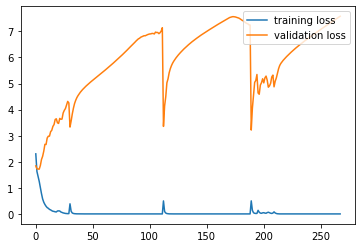

sample 3


<ipython-input-7-0af1aa155378>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
<ipython-input-7-0af1aa155378>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 2.3762 loss_val: 1.7690 time: 50.4042s
 Epoch: 0001 loss_train: 1.6425 loss_val: 1.6312 time: 50.6381s
 Epoch: 0002 loss_train: 1.4495 loss_val: 1.5978 time: 50.3900s
 Epoch: 0003 loss_train: 1.2543 loss_val: 1.6187 time: 50.4423s
 Epoch: 0004 loss_train: 1.0203 loss_val: 1.7216 time: 50.5274s
 Epoch: 0005 loss_train: 0.7742 loss_val: 1.9140 time: 50.4396s
 Epoch: 0006 loss_train: 0.5793 loss_val: 2.1237 time: 50.6212s
 Epoch: 0007 loss_train: 0.4491 loss_val: 2.2266 time: 50.6337s
 Epoch: 0008 loss_train: 0.3706 loss_val: 2.3891 time: 50.3100s
 Epoch: 0009 loss_train: 0.3133 loss_val: 2.6014 time: 50.5171s
 Epoch: 0010 loss_train: 0.2739 loss_val: 2.9191 time: 50.4678s
 Epoch: 0011 loss_train: 0.2356 loss_val: 2.8394 time: 50.3566s
 Epoch: 0012 loss_train: 0.1858 loss_val: 2.8766 time: 50.6615s
 Epoch: 0013 loss_train: 0.1445 loss_val: 2.9214 time: 50.4110s
 Epoch: 0014 loss_train: 0.1183 loss_val: 2.9905 time: 50.4815s
 Epoch: 0015 loss_train: 0.0999 loss_val

 Epoch: 0129 loss_train: 0.0182 loss_val: 4.5839 time: 55.6567s
 Epoch: 0130 loss_train: 0.0078 loss_val: 4.8823 time: 50.6786s
 Epoch: 0131 loss_train: 0.0029 loss_val: 5.0290 time: 52.7023s
 Epoch: 0132 loss_train: 0.0009 loss_val: 5.1755 time: 53.1949s
 Epoch: 0133 loss_train: 0.0004 loss_val: 5.2445 time: 52.0382s
 Epoch: 0134 loss_train: 0.0003 loss_val: 5.3026 time: 51.0177s
 Epoch: 0135 loss_train: 0.0002 loss_val: 5.3523 time: 50.2392s
 Epoch: 0136 loss_train: 0.0001 loss_val: 5.3956 time: 49.8958s
 Epoch: 0137 loss_train: 0.0001 loss_val: 5.4365 time: 49.8797s
 Epoch: 0138 loss_train: 0.0001 loss_val: 5.4743 time: 49.7540s
 Epoch: 0139 loss_train: 0.0001 loss_val: 5.5107 time: 49.8863s
 Epoch: 0140 loss_train: 0.0001 loss_val: 5.5467 time: 49.8037s
 Epoch: 0141 loss_train: 0.0001 loss_val: 5.5810 time: 50.2979s
 Epoch: 0142 loss_train: 0.0000 loss_val: 5.6154 time: 50.0858s
 Epoch: 0143 loss_train: 0.0000 loss_val: 5.6485 time: 50.2611s
 Epoch: 0144 loss_train: 0.0000 loss_val

 Epoch: 0257 loss_train: 0.0000 loss_val: 7.1680 time: 50.0479s
 Epoch: 0258 loss_train: 0.0000 loss_val: 7.1900 time: 49.9811s
 Epoch: 0259 loss_train: 0.0000 loss_val: 7.2122 time: 49.9127s
 Epoch: 0260 loss_train: 0.0000 loss_val: 7.2343 time: 50.1388s
 Epoch: 0261 loss_train: 0.0000 loss_val: 7.2554 time: 50.9554s
 Epoch: 0262 loss_train: 0.0000 loss_val: 7.2765 time: 49.9549s
 Epoch: 0263 loss_train: 0.0000 loss_val: 7.2999 time: 49.7696s
 Epoch: 0264 loss_train: 0.0000 loss_val: 7.3229 time: 49.6265s
 Epoch: 0265 loss_train: 0.0000 loss_val: 7.3428 time: 53.3281s
 Epoch: 0266 loss_train: 0.0000 loss_val: 7.3582 time: 52.8580s
 Epoch: 0267 loss_train: 0.0000 loss_val: 7.3726 time: 49.5502s
 Epoch: 0268 loss_train: 0.0000 loss_val: 7.3782 time: 49.8509s
 Epoch: 0269 loss_train: 0.0000 loss_val: 7.3808 time: 49.4653s
 Epoch: 0270 loss_train: 0.0000 loss_val: 7.3796 time: 49.5150s
 Epoch: 0271 loss_train: 0.0000 loss_val: 7.3689 time: 49.4496s
 Epoch: 0272 loss_train: 0.0000 loss_val

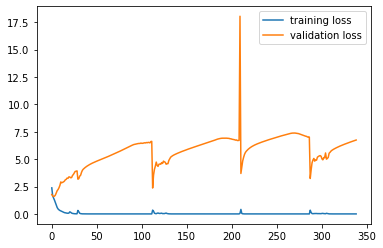

sample 4


<ipython-input-7-0af1aa155378>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
<ipython-input-7-0af1aa155378>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 2.3333 loss_val: 1.7815 time: 50.4667s
 Epoch: 0001 loss_train: 1.6332 loss_val: 1.6968 time: 50.3217s
 Epoch: 0002 loss_train: 1.4409 loss_val: 1.6997 time: 50.8658s
 Epoch: 0003 loss_train: 1.2343 loss_val: 1.8062 time: 50.9863s
 Epoch: 0004 loss_train: 0.9825 loss_val: 2.0231 time: 50.6956s
 Epoch: 0005 loss_train: 0.7294 loss_val: 2.2396 time: 50.2377s
 Epoch: 0006 loss_train: 0.5339 loss_val: 2.4310 time: 50.6565s
 Epoch: 0007 loss_train: 0.4197 loss_val: 2.6229 time: 54.7579s
 Epoch: 0008 loss_train: 0.3618 loss_val: 2.7856 time: 50.1102s
 Epoch: 0009 loss_train: 0.3356 loss_val: 3.0157 time: 50.6916s
 Epoch: 0010 loss_train: 0.2754 loss_val: 3.3211 time: 50.4982s
 Epoch: 0011 loss_train: 0.2168 loss_val: 3.2663 time: 50.5817s
 Epoch: 0012 loss_train: 0.1692 loss_val: 3.2600 time: 50.3541s
 Epoch: 0013 loss_train: 0.1362 loss_val: 3.2168 time: 50.4780s
 Epoch: 0014 loss_train: 0.1113 loss_val: 3.3145 time: 50.3558s
 Epoch: 0015 loss_train: 0.0952 loss_val

 Epoch: 0128 loss_train: 0.0096 loss_val: 5.0576 time: 41.6744s
 Epoch: 0129 loss_train: 0.0742 loss_val: 4.2985 time: 41.5844s
 Epoch: 0130 loss_train: 0.1388 loss_val: 4.2358 time: 41.4989s
 Epoch: 0131 loss_train: 0.0356 loss_val: 4.5386 time: 41.4992s
 Epoch: 0132 loss_train: 0.0141 loss_val: 4.9737 time: 41.8109s
 Epoch: 0133 loss_train: 0.0051 loss_val: 5.1073 time: 41.5289s
 Epoch: 0134 loss_train: 0.0015 loss_val: 5.2331 time: 41.5644s
 Epoch: 0135 loss_train: 0.0006 loss_val: 5.3748 time: 41.7072s
 Epoch: 0136 loss_train: 0.0003 loss_val: 5.4683 time: 41.7446s
 Epoch: 0137 loss_train: 0.0003 loss_val: 5.5388 time: 41.5356s
 Epoch: 0138 loss_train: 0.0002 loss_val: 5.6009 time: 41.6183s
 Epoch: 0139 loss_train: 0.0002 loss_val: 5.6561 time: 41.6970s
 Epoch: 0140 loss_train: 0.0001 loss_val: 5.7066 time: 41.6563s
 Epoch: 0141 loss_train: 0.0001 loss_val: 5.7540 time: 41.5979s
 Epoch: 0142 loss_train: 0.0001 loss_val: 5.7977 time: 41.6646s
 Epoch: 0143 loss_train: 0.0001 loss_val

 Epoch: 0257 loss_train: 0.0000 loss_val: 7.6209 time: 41.4917s
 Epoch: 0258 loss_train: 0.0000 loss_val: 7.6469 time: 41.7652s
 Epoch: 0259 loss_train: 0.0000 loss_val: 7.6736 time: 41.6057s
 Epoch: 0260 loss_train: 0.0000 loss_val: 7.7010 time: 41.7193s
 Epoch: 0261 loss_train: 0.0000 loss_val: 7.7270 time: 41.6120s
 Epoch: 0262 loss_train: 0.0000 loss_val: 7.7529 time: 41.7387s
 Epoch: 0263 loss_train: 0.0000 loss_val: 7.7784 time: 41.5598s
 Epoch: 0264 loss_train: 0.0000 loss_val: 7.8033 time: 41.6901s
 Epoch: 0265 loss_train: 0.0000 loss_val: 7.8285 time: 41.7285s
 Epoch: 0266 loss_train: 0.0000 loss_val: 7.8522 time: 41.6689s
 Epoch: 0267 loss_train: 0.0000 loss_val: 7.8765 time: 41.5973s
 Epoch: 0268 loss_train: 0.0000 loss_val: 7.8977 time: 41.7464s
 Epoch: 0269 loss_train: 0.0000 loss_val: 7.9169 time: 41.3855s
 Epoch: 0270 loss_train: 0.0000 loss_val: 7.9342 time: 41.6468s
 Epoch: 0271 loss_train: 0.0000 loss_val: 7.9426 time: 41.7186s
 Epoch: 0272 loss_train: 0.0000 loss_val

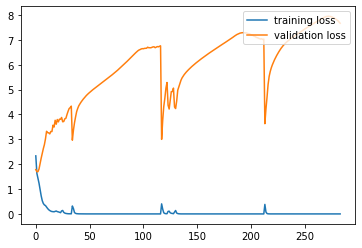

sample 5


<ipython-input-7-0af1aa155378>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
<ipython-input-7-0af1aa155378>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 2.3185 loss_val: 1.8054 time: 41.5366s
 Epoch: 0001 loss_train: 1.6336 loss_val: 1.6935 time: 41.6241s
 Epoch: 0002 loss_train: 1.4539 loss_val: 1.6319 time: 41.5251s
 Epoch: 0003 loss_train: 1.2642 loss_val: 1.6929 time: 41.8309s
 Epoch: 0004 loss_train: 1.0380 loss_val: 1.8359 time: 41.6783s
 Epoch: 0005 loss_train: 0.7972 loss_val: 2.0078 time: 41.8574s
 Epoch: 0006 loss_train: 0.5997 loss_val: 2.3936 time: 41.6676s
 Epoch: 0007 loss_train: 0.4692 loss_val: 2.3558 time: 41.6193s
 Epoch: 0008 loss_train: 0.3901 loss_val: 2.5430 time: 41.5226s
 Epoch: 0009 loss_train: 0.3547 loss_val: 2.7212 time: 41.9254s
 Epoch: 0010 loss_train: 0.3050 loss_val: 2.7289 time: 41.6025s
 Epoch: 0011 loss_train: 0.2407 loss_val: 2.8454 time: 41.6192s
 Epoch: 0012 loss_train: 0.1896 loss_val: 2.9334 time: 41.5924s
 Epoch: 0013 loss_train: 0.1523 loss_val: 3.1142 time: 41.5760s
 Epoch: 0014 loss_train: 0.1222 loss_val: 3.1976 time: 41.7034s
 Epoch: 0015 loss_train: 0.1018 loss_val

 Epoch: 0129 loss_train: 0.1176 loss_val: 4.2703 time: 41.8065s
 Epoch: 0130 loss_train: 0.0520 loss_val: 4.4588 time: 41.7281s
 Epoch: 0131 loss_train: 0.0251 loss_val: 4.6017 time: 41.3984s
 Epoch: 0132 loss_train: 0.0118 loss_val: 4.6316 time: 41.6293s
 Epoch: 0133 loss_train: 0.0047 loss_val: 4.9644 time: 41.7438s
 Epoch: 0134 loss_train: 0.0018 loss_val: 5.1074 time: 41.6031s
 Epoch: 0135 loss_train: 0.0007 loss_val: 5.2741 time: 41.5327s
 Epoch: 0136 loss_train: 0.0004 loss_val: 5.3617 time: 41.7300s
 Epoch: 0137 loss_train: 0.0002 loss_val: 5.4229 time: 41.5320s
 Epoch: 0138 loss_train: 0.0002 loss_val: 5.4755 time: 41.3989s
 Epoch: 0139 loss_train: 0.0001 loss_val: 5.5217 time: 41.7657s
 Epoch: 0140 loss_train: 0.0001 loss_val: 5.5641 time: 41.5696s
 Epoch: 0141 loss_train: 0.0001 loss_val: 5.6057 time: 41.5319s
 Epoch: 0142 loss_train: 0.0001 loss_val: 5.6446 time: 41.4501s
 Epoch: 0143 loss_train: 0.0001 loss_val: 5.6830 time: 41.7249s
 Epoch: 0144 loss_train: 0.0001 loss_val

 Epoch: 0258 loss_train: 0.0000 loss_val: 7.4138 time: 41.7393s
 Epoch: 0259 loss_train: 0.0000 loss_val: 7.4432 time: 41.4958s
 Epoch: 0260 loss_train: 0.0000 loss_val: 7.4708 time: 41.6995s
 Epoch: 0261 loss_train: 0.0000 loss_val: 7.4975 time: 41.5751s
 Epoch: 0262 loss_train: 0.0000 loss_val: 7.5240 time: 41.7444s
 Epoch: 0263 loss_train: 0.0000 loss_val: 7.5513 time: 41.5141s
 Epoch: 0264 loss_train: 0.0000 loss_val: 7.5784 time: 41.6013s
 Epoch: 0265 loss_train: 0.0000 loss_val: 7.6040 time: 41.7865s
 Epoch: 0266 loss_train: 0.0000 loss_val: 7.6276 time: 41.6291s
 Epoch: 0267 loss_train: 0.0000 loss_val: 7.6512 time: 41.3993s
 Epoch: 0268 loss_train: 0.0000 loss_val: 7.6737 time: 41.7435s
 Epoch: 0269 loss_train: 0.0000 loss_val: 7.6950 time: 41.6929s
 Epoch: 0270 loss_train: 0.0000 loss_val: 7.7099 time: 41.6343s
 Epoch: 0271 loss_train: 0.0000 loss_val: 7.7234 time: 41.4816s
 Epoch: 0272 loss_train: 0.0000 loss_val: 7.7311 time: 41.7177s
 Epoch: 0273 loss_train: 0.0000 loss_val

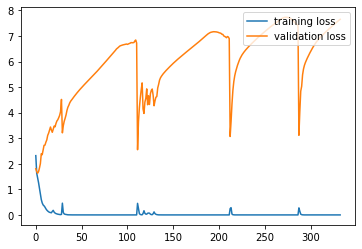

In [8]:
nSamples=6

for sample_s in range(nSamples):
    print('sample',sample_s)
    seed=sample_s
    np.random.seed(sample_s)
    pctVal=0.1

    allIdx=np.arange(finalPartition_keep_input.size)
    np.random.shuffle(allIdx)
    valIdx=allIdx[:int(pctVal*allIdx.size)]
    trainIdx=allIdx[int(pctVal*allIdx.size):]

    logsavepath_train_curr=os.path.join(logsavepath,str(sample_s))
    modelsavepath_train_curr=os.path.join(modelsavepath,str(sample_s))
    plotsavepath_train_curr=os.path.join(plotsavepath,str(sample_s))
    if not os.path.exists(logsavepath_train_curr):
        os.mkdir(logsavepath_train_curr)
    if not os.path.exists(modelsavepath_train_curr):
        os.mkdir(modelsavepath_train_curr)
    if not os.path.exists(plotsavepath_train_curr):
        os.mkdir(plotsavepath_train_curr)

        
    #construct labels

    finalPartition_keep_input_unique,labels,finalPartition_keep_input_counts=np.unique(finalPartition_keep_input[trainIdx],return_counts=True,return_inverse=True)
    weights=1/finalPartition_keep_input_counts
    weights=weights/np.sum(weights)

    loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).cuda().float())
    finalPartition_keep_input_unique_val,labels_val,finalPartition_keep_input_counts_val=np.unique(finalPartition_keep_input[valIdx],return_counts=True,return_inverse=True)

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    if modelname_train=='resnet18':
        model=torchvision.models.resnet18(num_classes=finalPartition_keep_input_unique.size)
        model.conv1=torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
    elif modelname_train=='alexnet':
        model=torchvision.models.alexnet(num_classes=cnames.size)
        model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    elif modelname_train=='cnn_base':
        model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)
    model.cuda()
    optimizer_clf = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loss=[np.inf]*epochs
    val_loss=[np.inf]*epochs

    t_ep=time.time()

    epCounts=0
    for ep in range(epochs):
        train_loss[ep],val_loss[ep]=train(ep,model,optimizer_clf,allImg[trainIdx],allImg[valIdx],torch.tensor(labels),torch.tensor(labels_val))

        if ep>50 and val_loss[ep]>=val_loss[ep-50]:
            epCounts+=1

        if epCounts>150:
            break


        if ep%saveFreq == (saveFreq-1):
            torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_train_curr,'ep'+str(ep)+'.pt'))


        model.cuda()
        torch.cuda.empty_cache()
    print(' total time: {:.4f}s'.format(time.time() - t_ep))


    with open(os.path.join(logsavepath_train_curr,'train_loss'), 'wb') as output:
        pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath_train_curr,'val_loss'), 'wb') as output:
        pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)


    plt.plot(np.arange(epochs),train_loss)
    plt.plot(np.arange(epochs),val_loss)
    plt.legend(['training loss','validation loss'],loc='upper right')
    plt.savefig(os.path.join(plotsavepath_train_curr,'loss.jpg'))
    plt.show()



In [12]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',ctorder=None,vmin=None,vmax=None):
    if ctorder is None:
        ctorder=np.unique(ctlist)
    res=np.zeros((np.unique(labels).size,ctorder.size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=vmin,vmax=vmax)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(ctorder.size))
    ax.set_xticklabels(ctorder)
#     resplot=np.around(res,3)
#     for i in range(resplot.shape[0]):
#         for j in range(resplot.shape[1]):
#             text = ax.text(j, i, resplot[i, j],
#                            ha="center", va="center", color="r")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    return res



In [ ]:
res_val=np.zeros((nSamples,finalPartition_keep_input_unique.size,finalPartition_keep_input_unique.size))
correctCount_val=[None]*nSamples

for sample_s in range(nSamples):
    seed=sample_s
    np.random.seed(sample_s)
    pctVal=0.1

    allIdx=np.arange(finalPartition_keep_input.size)
    np.random.shuffle(allIdx)
    valIdx=allIdx[:int(pctVal*allIdx.size)]
    trainIdx=allIdx[int(pctVal*allIdx.size):]

    logsavepath_train_curr=os.path.join(logsavepath,str(sample_s))
    modelsavepath_train_curr=os.path.join(modelsavepath,str(sample_s))
    plotsavepath_train_curr=os.path.join(plotsavepath,str(sample_s))
    
    finalPartition_keep_input_unique,labels,finalPartition_keep_input_counts=np.unique(finalPartition_keep_input[trainIdx],return_counts=True,return_inverse=True)
    weights=1/finalPartition_keep_input_counts
    weights=weights/np.sum(weights)

    loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).cuda().float())
    finalPartition_keep_input_unique_val,labels_val,finalPartition_keep_input_counts_val=np.unique(finalPartition_keep_input[valIdx],return_counts=True,return_inverse=True)

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    if modelname_train=='resnet18':
        model=torchvision.models.resnet18(num_classes=finalPartition_keep_input_unique.size)
        model.conv1=torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
    elif modelname_train=='alexnet':
        model=torchvision.models.alexnet(num_classes=finalPartition_keep_input_unique.size)
        model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    elif modelname_train=='cnn_base':
        model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,finalPartition_keep_input_unique.size)
    model.cuda()

    with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
        val_loss=pickle.load(output)
    minlossepoch=np.argmin(val_loss)
    minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
    if minlossepoch_saved==-1:
        minlossepoch_saved=saveFreq-1
    if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
        if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
            minlossepoch_saved=minlossepoch_saved+saveFreq
        else:
            minlossepoch_saved=minlossepoch_saved-saveFreq
    if minlossepoch_saved==-1:
        minlossepoch_saved=saveFreq-1
    model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))

    #validation samples
    with torch.no_grad():
        model.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        pred_curr=np.array([])
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            val_labels=torch.tensor(labels_val[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]).cuda().long()
            valInput=torch.tensor(allImg[valIdx_i]).cuda().float()


            pred = model(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()
            pred_curr=np.concatenate((pred_curr,np.argmax(pred.detach().cpu().numpy(),axis=1)))

        loss_val_all=loss_val_all/nvalBatches

    print('loss_val: {:.4f}'.format(loss_val_all))
    correctCount=np.sum(pred_curr==labels_val)/pred_curr.size
    print('acc: {:.4f}'.format(correctCount))

    pred_curr=pred_curr.astype(int)
    res_val[sample_s][:,np.unique(pred_curr)]=plotCTcomp(finalPartition_keep_input_unique[labels_val],finalPartition_keep_input_unique[pred_curr],plotsavepath_train_curr,'confusion_val',False,addname='',ctorder=None,vmin=0,vmax=1)
    correctCount_val[sample_s]=correctCount
    
    
    
with open(os.path.join(plotsavepath,'acc_val'), 'wb') as output:
    pickle.dump(correctCount_val, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(plotsavepath,'confusion_val'), 'wb') as output:
    pickle.dump(res_val, output, pickle.HIGHEST_PROTOCOL)

